<a href="https://colab.research.google.com/github/Neafiol/Tinkoff/blob/master/gan/ganexemple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install git+https://github.com/pytorch/vision.git

  Cloning https://github.com/pytorch/vision.git to /tmp/pip-req-build-pz0319av
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ipbdyeq/wheels/04/6d/bf/cc14a58bae32d07d1c7d23833dc5ea655e477ff25061b8cd57
Successfully built torchvision


In [0]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [0]:
def normal_init(m, mean, stand_deav):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, stand_deav)
        m.bias.data.zero_()

In [0]:
device = torch.device('cuda:0')  # не забудьте включить GPU

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
image_size = 64
batch_size = 128
latent_size = 100
lr = 0.0002

In [0]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # Normalize здесь приводит значения в промежуток [-1, 1]
])

dataset = datasets.CelebA('data', download=True, transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [0]:
class G_128(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size , 64 * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 16, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 , 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

In [0]:
class D_128(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(latent_size, 64, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 4, 64 * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 64 * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()

        )

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d( latent_size, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [0]:
G = Generator().to(device)

In [0]:
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [0]:
D = Discriminator().to(device)

In [0]:
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [0]:
criterion  = nn.BCELoss()
criterion = criterion.to(device)

In [0]:
z_f = torch.randn(64, latent_size, 1, 1, device=device)

In [0]:
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
optim_G = optim.Adam(G.parameters(), lr = lr, betas = (0.5, 0.999))

In [0]:
t_h = {}
t_h['G_losses'] = []
t_h['D_losses'] = []

In [0]:
optim_D = optim.Adam(D.parameters(), lr = lr, betas = (0.5, 0.999))

In [0]:
print(D(G(z_f)))

tensor([[[[0.6821]]],


        [[[0.8269]]],


        [[[0.5403]]],


        [[[0.5170]]],


        [[[0.4855]]],


        [[[0.3115]]],


        [[[0.7523]]],


        [[[0.9005]]],


        [[[0.9545]]],


        [[[0.7727]]],


        [[[0.9250]]],


        [[[0.5041]]],


        [[[0.4825]]],


        [[[0.8078]]],


        [[[0.9068]]],


        [[[0.9522]]],


        [[[0.7882]]],


        [[[0.6440]]],


        [[[0.8618]]],


        [[[0.9643]]],


        [[[0.6618]]],


        [[[0.8917]]],


        [[[0.9267]]],


        [[[0.8923]]],


        [[[0.8621]]],


        [[[0.2736]]],


        [[[0.8909]]],


        [[[0.8255]]],


        [[[0.8542]]],


        [[[0.5985]]],


        [[[0.6550]]],


        [[[0.7121]]],


        [[[0.6724]]],


        [[[0.8150]]],


        [[[0.9283]]],


        [[[0.8329]]],


        [[[0.9744]]],


        [[[0.2344]]],


        [[[0.5993]]],


        [[[0.6644]]],


        [[[0.5996]]],


        [[[0.769

0/10, 7.861635220125786%
  G loss: 17.816207885742188
  D loss: 0.4416220784187317
0/10, 15.723270440251572%
  G loss: 4.6012725830078125
  D loss: 0.5566481351852417
0/10, 23.58490566037736%
  G loss: 4.252906799316406
  D loss: 1.0918210744857788
0/10, 31.446540880503143%
  G loss: 1.4688851833343506
  D loss: 0.7017196416854858
0/10, 39.308176100628934%
  G loss: 3.224334955215454
  D loss: 0.5073954463005066


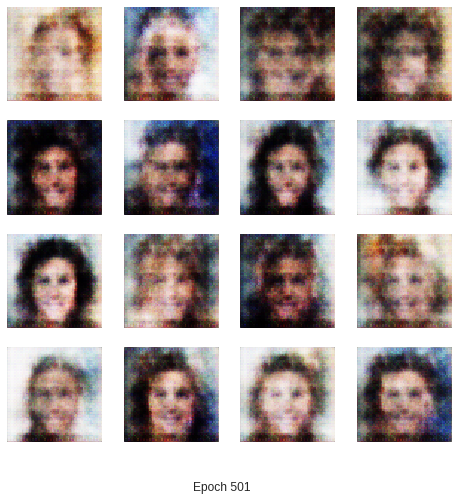

0/10, 47.16981132075472%
  G loss: 5.69249153137207
  D loss: 0.7311834096908569
0/10, 55.0314465408805%
  G loss: 7.956200122833252
  D loss: 0.9338307976722717
0/10, 62.893081761006286%
  G loss: 5.882460117340088
  D loss: 0.5790459513664246
0/10, 70.75471698113208%
  G loss: 4.010619640350342
  D loss: 0.5132181644439697
0/10, 78.61635220125787%
  G loss: 2.636601686477661
  D loss: 0.45228391885757446


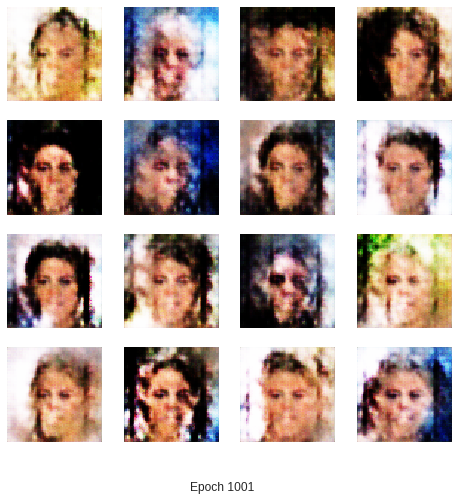

0/10, 86.47798742138365%
  G loss: 4.628134727478027
  D loss: 0.41483592987060547
0/10, 94.33962264150944%
  G loss: 3.5893068313598633
  D loss: 1.4011551141738892
loss_discrim: 0.667, loss_generator: 5.989


FileNotFoundError: ignored

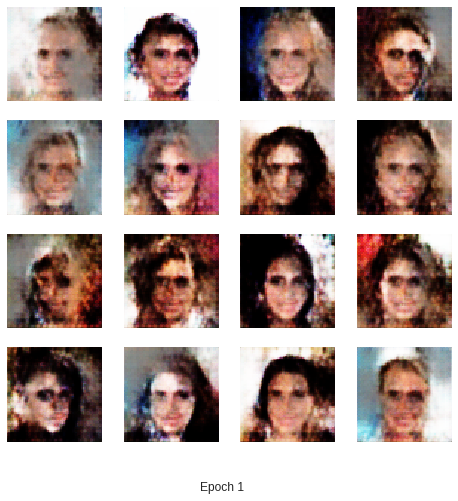

In [0]:
ii = 0
num_epochs = 10
for epoch in range(num_epochs):
  iters = 0
    
  G_ls = []
  D_ls = []
  for data, _ in loader:
    
    y_real = data.to(device)
    #print(y_real.size())
    b_s = y_real.size(0)
    #print(b_s)
    if b_s != 128:
      continue
    D.zero_grad()
    lbl = torch.full((b_s,), 1, device = device)
    #print(lbl)
    out = D(y_real).squeeze()
    lD_real = criterion(out, lbl)
    lD_real.backward()
    
    
    zz = torch.randn(batch_size, latent_size, 1, 1, device=device)
    y_fake = G(zz)
    lbl.fill_(0)
    out = D(y_fake.detach()).squeeze()
    lD_fake = criterion(out, lbl)
    lD_fake.backward()
    lD = lD_real + lD_fake
    optim_D.step()
    
    
    
    G.zero_grad()
    lbl.fill_(1)
    out = D(y_fake).squeeze()
    lG = criterion(out, lbl)
    lG.backward()
    optim_G.step()
    iters += 1

    G_ls.append(lG.item())
    D_ls.append(lD.item())
    if iters % 100 == 0:
            # Выведем информацию о том, как наша сеть справляется
      print(f'{epoch}/{num_epochs}, {iters/len(loader)*100}%')
      print(f'  G loss: {lG.item()}')
      print(f'  D loss: {lD.item()}')
      ii += 1
      show_result( ii+ 1, path = 'gif4/' + str(ii)+'.png', isFix = True, show = False)
    if iters % 500 == 0:
      show_result(iters + 1,path = 'res/' + str(epoch + 1)+'ep'+str(iters)+'it' + '.png', isFix = True)
  print('='*100)
  print('loss_discrim: %.3f, loss_generator: %.3f'%(torch.mean(torch.tensor(D_ls)),torch.mean(torch.tensor(G_ls))))
  show_result(epoch + 1,path = 'random/' + str(epoch + 1) + '.png')
  t_h['D_losses'].append(torch.mean(torch.FloatTensor(D_ls)))
  t_h['G_losses'].append(torch.mean(torch.FloatTensor(G_ls)))
    

In [0]:
import matplotlib.pyplot as plt
import itertools

In [0]:
def show_result(num_epoch, show = True, save = True, path = 'result.png', isFix=False):
    z = torch.randn((8 * 8, latent_size)).view(-1, latent_size, 1, 1)
    z = z.to(device)
    G.eval()
    if isFix:
        test_images = G(z_f)
    else:
        test_images = G(z)
    G.train()

    size_figure_grid = 4
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(8, 8))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(4*4):
        i = k // 4
        j = k % 4
        ax[i, j].cla()
        ax[i, j].imshow((test_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [0]:
!mkdir res

In [0]:
torch.save(G,'G5ep.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
torch.save(D,'D120ep.pt')
torch.save(G,'G120ep.pt')


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
def show_train_hist(hist, show = False):
    x = range(len(hist['D_losses']))
    y1 = hist['D_losses']
    y2 = hist['G_losses']
    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')
    plt.xlabel('Iter')
    plt.ylabel('Loss')
    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.close()

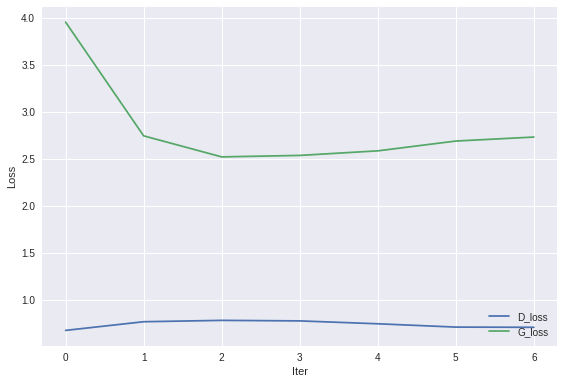

In [0]:
show_train_hist(t_h,show = True)

In [0]:
!mkdir gif4


In [0]:
!ls

D10ep.pt   D5ep.pt  G10ep.pt   G5ep.pt	gif2	res
D120ep.pt  data     G120ep.pt  gif	random	sample_data


NameError: ignored

In [0]:
import os
import imageio
images = []
names = []
for (dirpath, _, filenames) in os.walk("./gif3/"):
    for filename in filenames:
        names.append(filename)
names.sort(key = lambda x: int(x.replace('.png','')))

In [0]:
for filename in names:
        img_name = './gif3/'+filename
        images.append(imageio.imread(img_name))

In [0]:
imageio.mimsave('./gif3/generation_animation.gif', images, fps=5)

In [0]:
ima